In [1]:
from google.colab import drive
drive.mount('/content/drive')
!unzip -d /content /content/drive/MyDrive/Data/snp452-data.mat.zip
!unzip -d /content /content/drive/MyDrive/Data/data_tsfresh_features.csv.zip

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Data/snp452-data.mat.zip
  inflating: /content/snp452-data.mat  
  inflating: /content/__MACOSX/._snp452-data.mat  
Archive:  /content/drive/MyDrive/Data/data_tsfresh_features.csv.zip
  inflating: /content/data_tsfresh_features.csv  
  inflating: /content/__MACOSX/._data_tsfresh_features.csv  


In [2]:
""" Install time-series modules """
!pip install tsfresh tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 17.4 MB/s eta 0:00:00


In [17]:
import numpy as np
import pandas as pd
import scipy.io as spio
import sklearn
import tslearn
from sklearn.preprocessing import normalize

# Data Description

<Axes: xlabel='classes'>

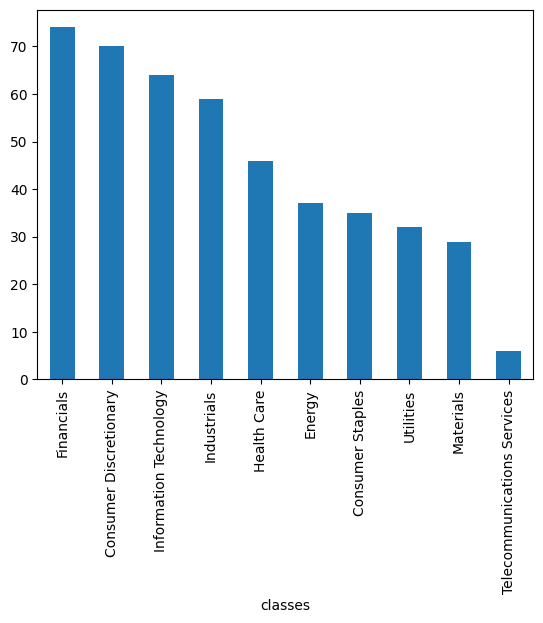

In [4]:
""" Read Data """
matdata = spio.loadmat('snp452-data.mat')

data = matdata['X']

codes = []
cls = []
for i in range(452):
    codes.append(matdata['stock'][0][i][0][0][0][0][1:-1])
    cls.append(matdata['stock'][0][i][0][0][2][0][1:-1])

data_df = pd.DataFrame(data.T)
info_df = pd.DataFrame({'classes' : cls, 'codes': codes})

info_df['classes'].value_counts().plot(kind='bar')


# Data Preprocessing

In [9]:
def smoothing(df, window_n, func:str):
  if func == 'mean':
    return df.rolling(window_n, axis=1).mean().dropna(axis=1, how='all')
  elif func == 'min':
    return df.rolling(window_n, axis=1).min().dropna(axis=1, how='all')
  elif func == 'max':
    return df.rolling(window_n, axis=1).max().dropna(axis=1, how='all')
  elif func == 'median':
    return df.rolling(window_n, axis=1).median().dropna(axis=1, how='all')
  else:
    assert 1 == 0, "Error !!!"

def diff(df, order):
  diff_df = df.diff(axis=1).dropna(axis=1, how='all')
  if order == 1:
    return diff_df
  elif order == 2:
    return diff_df.diff(axis=1).dropna(axis=1, how='all')
  else:
    assert 1 == 2, "No"

def mynormalize(df, func='mean'):
  if func == 'minmax':
    return (df-df.min())/(df.max()-df.min())
  elif func == 'mean':
    return (df-df.mean())/df.std()
  else:
    assert 1 == 2, "No"

def log_return(df):
  return np.log(1 + df.pct_change(axis=1).dropna(axis=1, how='all'))

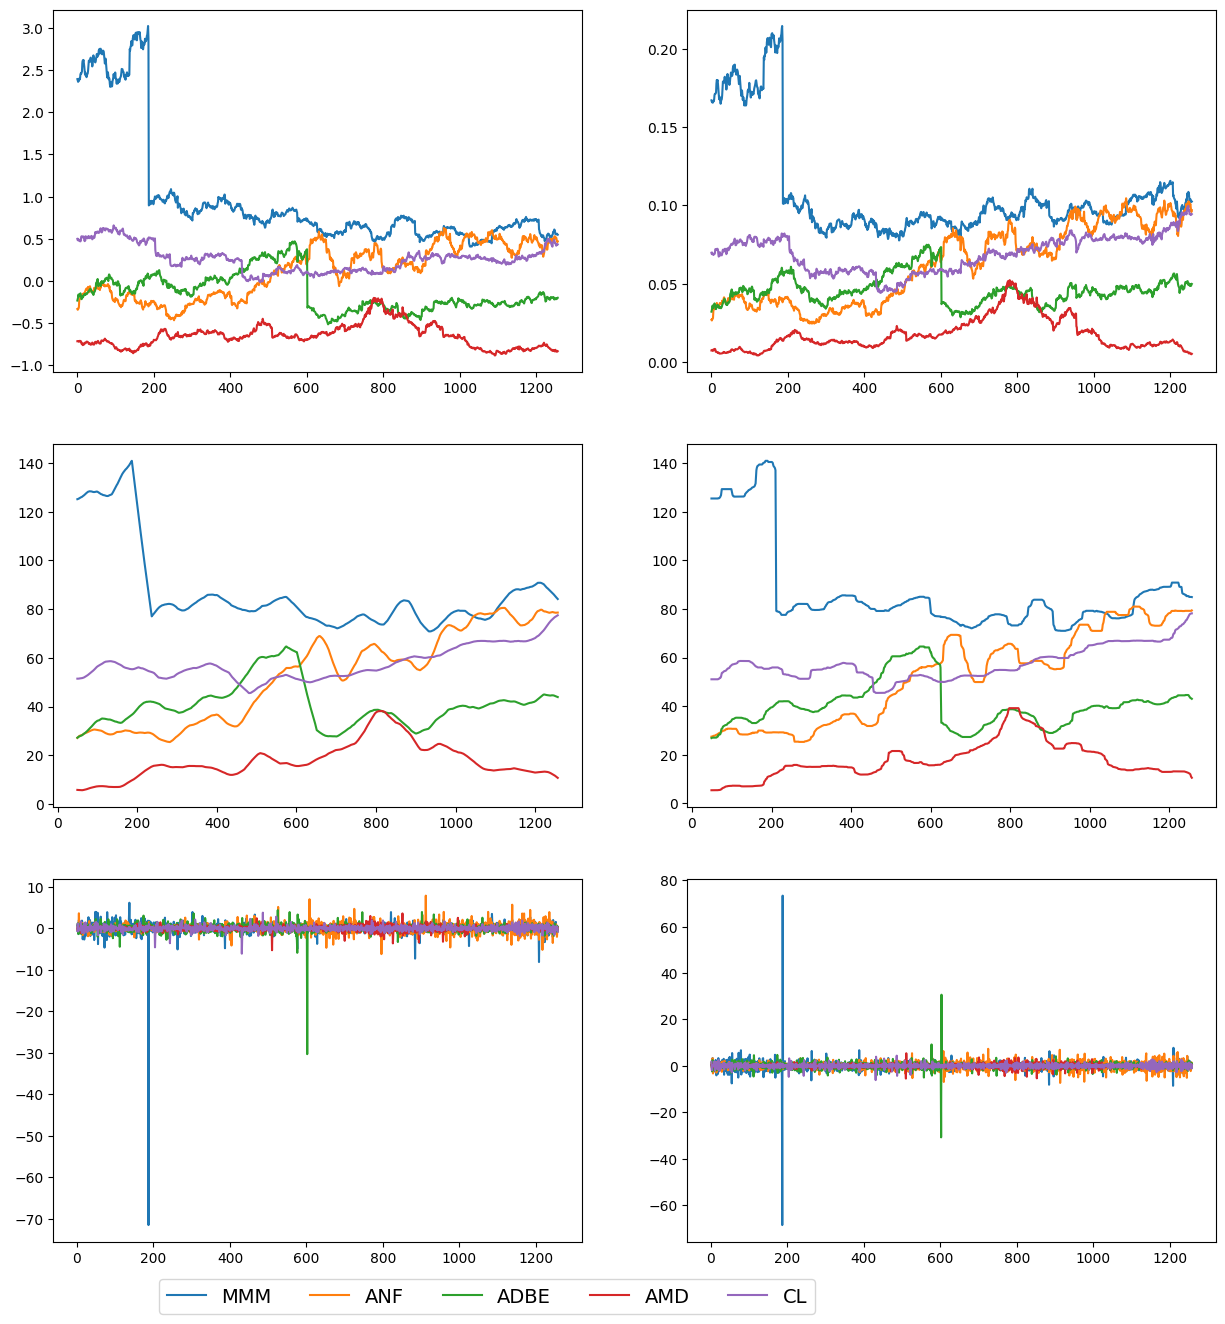

In [10]:
import matplotlib.pyplot as plt
def draw(ax, df, idxes:list):
  for i in idxes:
    ax.plot(df.iloc[i,:], label=info_df['codes'][i])

wind_n = 50
fig,axes = plt.subplots(3,2, figsize=(15,16))

idxes = [0, 3, 4, 5, 100]
draw(axes[1,0], smoothing(data_df, wind_n, 'mean'), idxes)
draw(axes[1,1], smoothing(data_df, wind_n, 'median'), idxes)
draw(axes[2,0], diff(data_df, 1), idxes)
draw(axes[2,1], diff(data_df, 2), idxes)
draw(axes[0,0], mynormalize(data_df, 'mean'), idxes)
draw(axes[0,1], mynormalize(data_df, 'minmax'), idxes)
plt.legend(ncol=5, loc=(-1., -0.2), fontsize=14)


# Data Visualization

In [8]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.5 MB/s eta 0:00:00


In [19]:
import umap
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn.decomposition import PCA, KernelPCA


def dimesion_reduction(df, n_comps):
  try:
    df = df.to_numpy()
  except:
    df = df
  reducer_pca = PCA(n_components=n_comps)
  embedding_pca = reducer_pca.fit_transform(df)

  embedding_kpca = KernelPCA(n_components=2,
                             kernel='cosine').fit_transform(df)

  reducer_umap = umap.UMAP(n_components=n_comps,random_state=42)
  embedding_umap = reducer_umap.fit_transform(df)

  embedding_tsne = TSNE(n_components=n_comps, learning_rate='auto',
                    init='random', perplexity=3).fit_transform(df)

  embedding_mds = MDS(n_components=n_comps,
                      normalized_stress='auto').fit_transform(df)

  embedding_isomap = Isomap(n_components=n_comps).fit_transform(df)
  return ( embedding_pca, embedding_kpca, embedding_umap, embedding_tsne, embedding_mds, embedding_isomap)

def remove_outlier(df, df_labels, thred=4):
  try:
    data = df.to_numpy()
  except:
    data = df
  norm_m = sum([np.linalg.norm(data[i]) for i in range(len(data))])/len(data)
  delete_idxes = []
  for i in range(len(data)):
    # print(norm_m, np.linalg.norm(data[i]))
    if np.linalg.norm(data[i]) > thred * norm_m:
      delete_idxes.append(i)
  print(delete_idxes)
  for idx in delete_idxes:
    df.iloc[idx,:] = np.nan
    df_labels.iloc[idx] = np.nan

  # print(df)
  return df.dropna(axis=0, how='any').to_numpy(), df_labels.dropna(axis=0, how='any').to_numpy()

In [20]:
def draw_sactters(ax, emb, labs, method_title):
    # assert len(emb) == len(labs)
    list_labs = np.array(
        list(set(labs)))
    for lab in list_labs:
      idxes_where = np.where(labs==lab)
      ax.scatter(emb[idxes_where][:,0], emb[idxes_where][:,1],
                 s=45, label=lab, alpha=0.5, lw=2)
    ax.set_title(method_title)
    ax.grid(linestyle='-', axis='both')

In [21]:
""" Preprocessed Data """
normalized_diff_df = mynormalize(diff(data_df, 1), 'minmax')
normalized_diff2_df = mynormalize(diff(data_df, 2), 'minmax')

sm_median_df = smoothing(data_df, 50, 'median')
sm_mean_df = smoothing(data_df, 50, 'mean')

normalized_data = mynormalize(data_df, 'mean')
pct_df = log_return(data_df)

## Row Data

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[94, 185, 432]
[]
[94, 432]
[94, 185, 432]


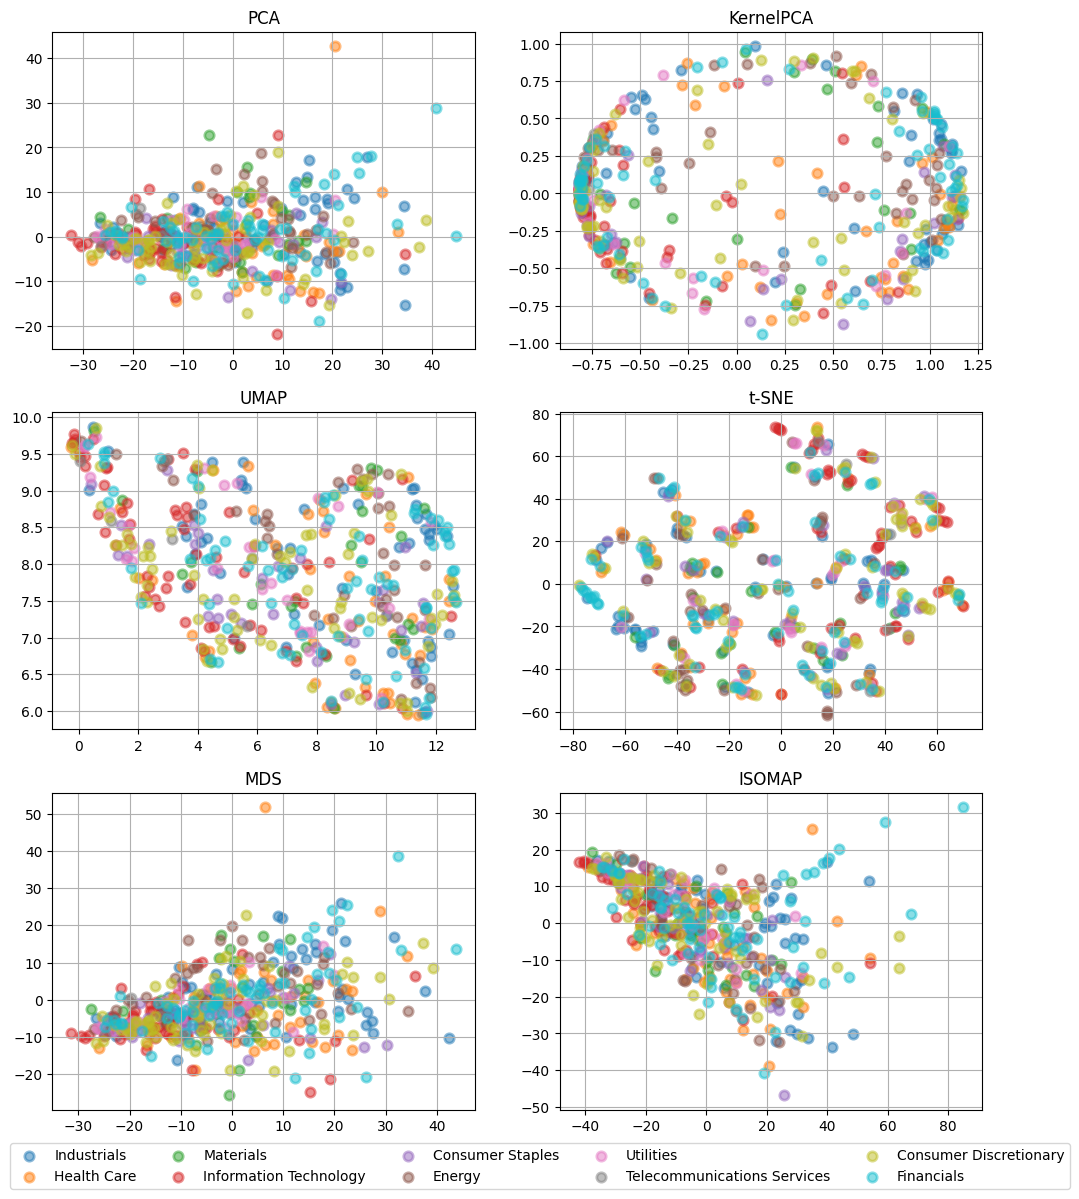

In [28]:
(embedding_pca,
 embedding_kpca,
 embedding_umap,
 embedding_tsne,
 embedding_mds,
 embedding_isomap) = dimesion_reduction(normalized_data, 2)

embedding_pca_ = remove_outlier(pd.DataFrame(embedding_pca).copy(),
                                info_df['classes'].copy())
embedding_kpca_ = remove_outlier(pd.DataFrame(embedding_kpca).copy(),
                                 info_df['classes'].copy())
embedding_isomap_ = remove_outlier(pd.DataFrame(embedding_isomap).copy(),
                                   info_df['classes'].copy())
embedding_mds_ = remove_outlier(pd.DataFrame(embedding_mds).copy(),
                                   info_df['classes'].copy())

fig,axes = plt.subplots(3,2, figsize=(12,14))
draw_sactters(axes[0,0], embedding_pca_[0], embedding_pca_[1], 'PCA')
draw_sactters(axes[0,1], embedding_kpca_[0], embedding_kpca_[1], 'KernelPCA')
draw_sactters(axes[1,0], embedding_umap, info_df['classes'], 'UMAP')
draw_sactters(axes[1,1], embedding_tsne, info_df['classes'], 't-SNE')
draw_sactters(axes[2,0], embedding_mds_[0], embedding_mds_[1], 'MDS')
draw_sactters(axes[2,1], embedding_isomap_[0], embedding_isomap_[1], 'ISOMAP')
plt.legend(ncol=5, loc=(-1.3, -0.25), fontsize=10)

## Features of time series

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[2, 56, 85, 180, 214, 438]
[]
[85, 214, 438]
[85, 214, 438]


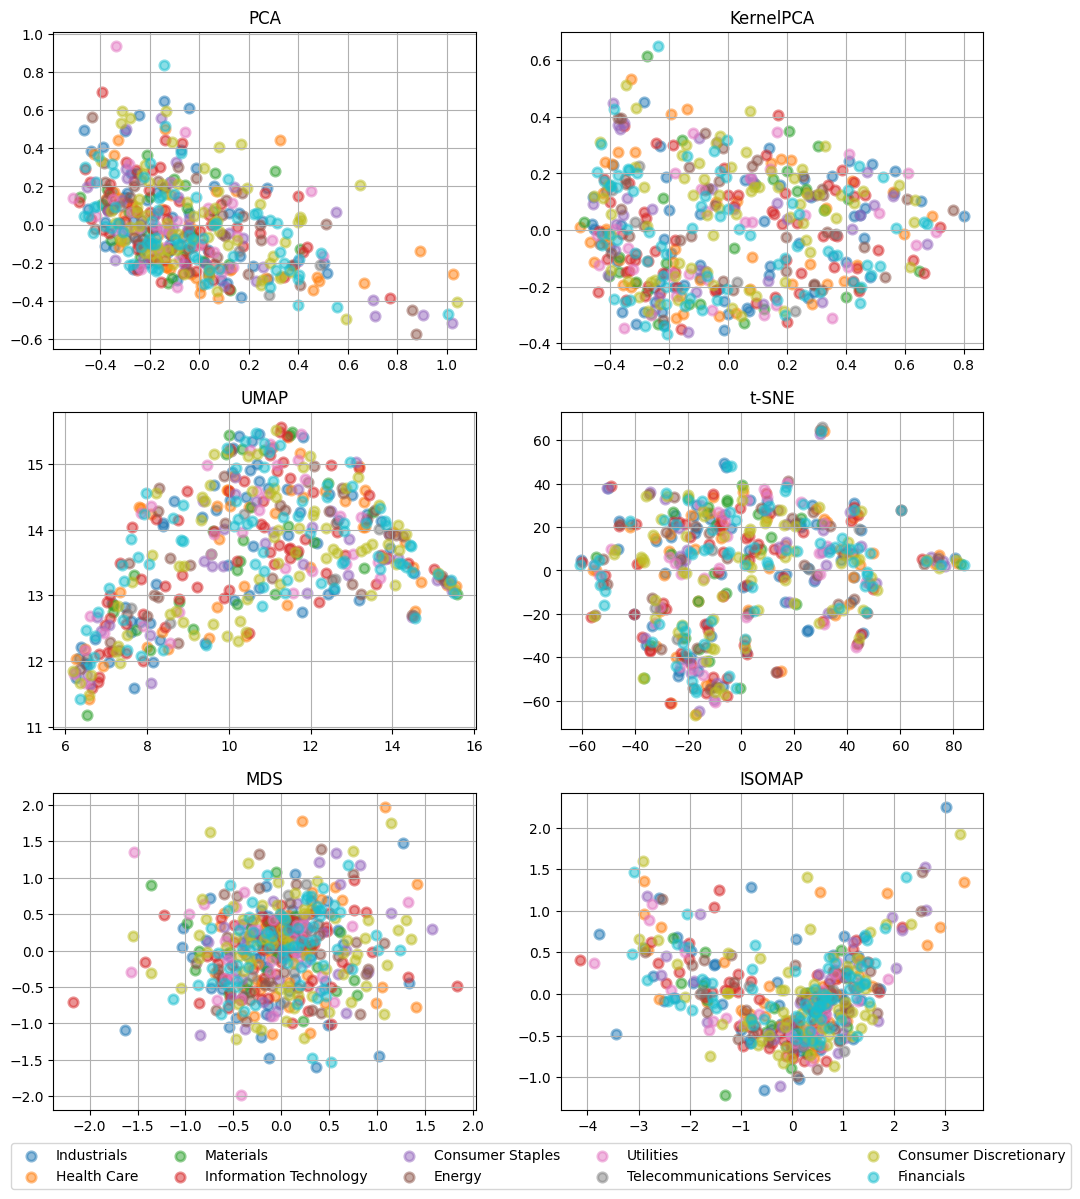

In [26]:
ana_df = pd.read_csv('/content/data_tsfresh_features.csv', index_col=0).dropna(axis=1, how='any')
ana_arr = normalize(ana_df.to_numpy(), norm='l2', axis=0)


(embedding_pca,
 embedding_kpca,
 embedding_umap,
 embedding_tsne,
 embedding_mds,
 embedding_isomap) = dimesion_reduction(ana_arr, 2)

embedding_pca_ = remove_outlier(pd.DataFrame(embedding_pca).copy(),
                                info_df['classes'].copy())
embedding_kpca_ = remove_outlier(pd.DataFrame(embedding_kpca).copy(),
                                 info_df['classes'].copy())
embedding_isomap_ = remove_outlier(pd.DataFrame(embedding_isomap).copy(),
                                   info_df['classes'].copy())
embedding_mds_ = remove_outlier(pd.DataFrame(embedding_mds).copy(),
                                   info_df['classes'].copy())

fig,axes = plt.subplots(3,2, figsize=(12,14))
draw_sactters(axes[0,0], embedding_pca_[0], embedding_pca_[1], 'PCA')
draw_sactters(axes[0,1], embedding_kpca_[0], embedding_kpca_[1], 'KernelPCA')
draw_sactters(axes[1,0], embedding_umap, info_df['classes'], 'UMAP')
draw_sactters(axes[1,1], embedding_tsne, info_df['classes'], 't-SNE')
draw_sactters(axes[2,0], embedding_mds_[0], embedding_mds_[1], 'MDS')
draw_sactters(axes[2,1], embedding_isomap_[0], embedding_isomap_[1], 'ISOMAP')
plt.legend(ncol=5, loc=(-1.3, -0.25), fontsize=10)

## Log return

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


[199, 285, 378, 407]
[]
[306]
[407]


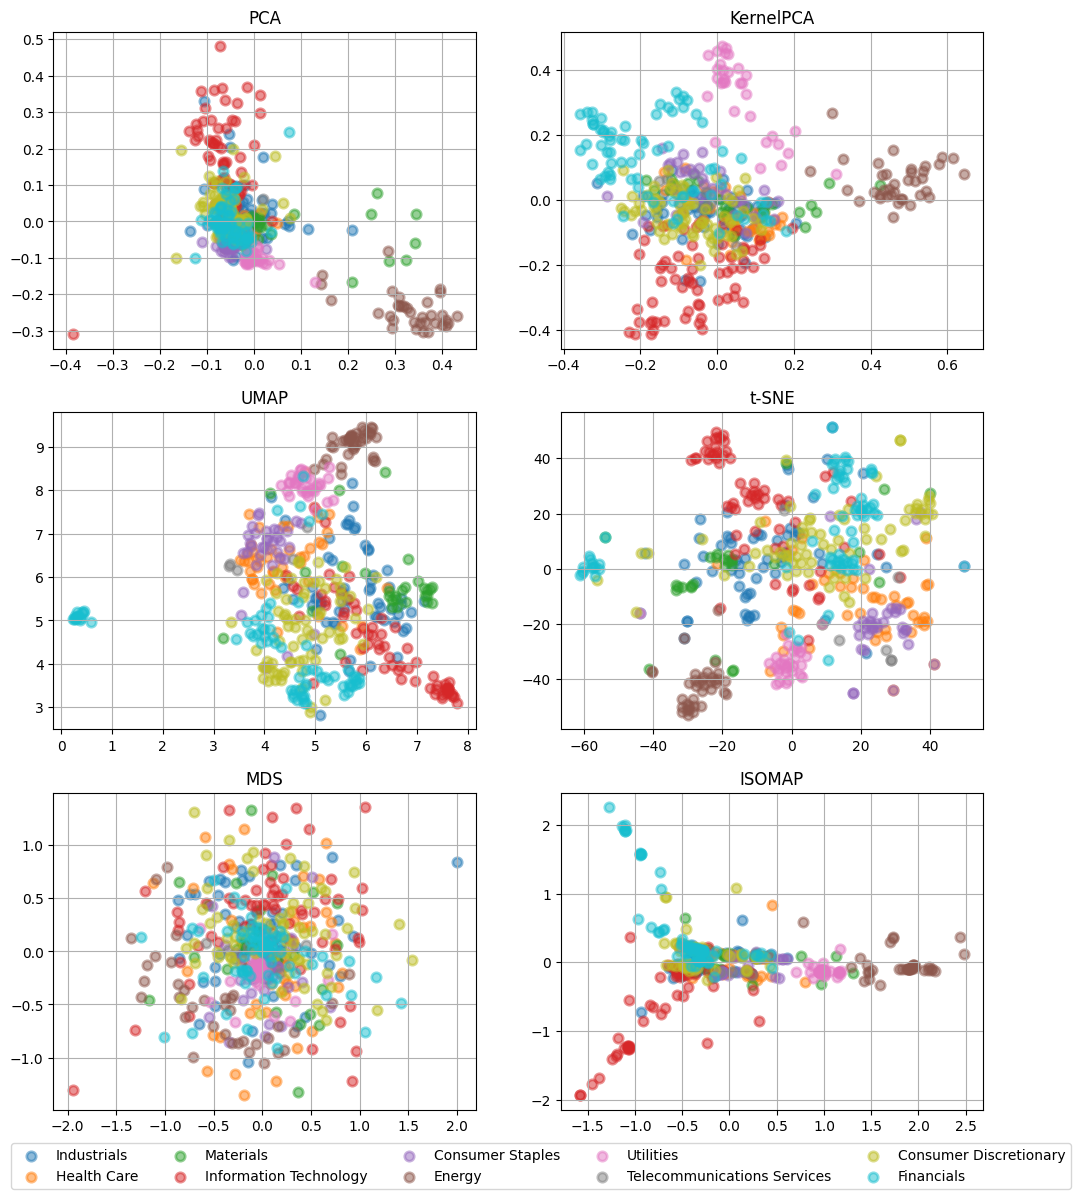

In [29]:
(embedding_pca,
 embedding_kpca,
 embedding_umap,
 embedding_tsne,
 embedding_mds,
 embedding_isomap) = dimesion_reduction(pct_df, 2)

embedding_pca_ = remove_outlier(pd.DataFrame(embedding_pca).copy(),
                                info_df['classes'].copy())
embedding_kpca_ = remove_outlier(pd.DataFrame(embedding_kpca).copy(),
                                 info_df['classes'].copy())
embedding_isomap_ = remove_outlier(pd.DataFrame(embedding_isomap).copy(),
                                   info_df['classes'].copy())
embedding_mds_ = remove_outlier(pd.DataFrame(embedding_mds).copy(),
                                   info_df['classes'].copy())

fig,axes = plt.subplots(3,2, figsize=(12,14))
draw_sactters(axes[0,0], embedding_pca_[0], embedding_pca_[1], 'PCA')
draw_sactters(axes[0,1], embedding_kpca_[0], embedding_kpca_[1], 'KernelPCA')
draw_sactters(axes[1,0], embedding_umap, info_df['classes'], 'UMAP')
draw_sactters(axes[1,1], embedding_tsne, info_df['classes'], 't-SNE')
draw_sactters(axes[2,0], embedding_mds_[0], embedding_mds_[1], 'MDS')
draw_sactters(axes[2,1], embedding_isomap_[0], embedding_isomap_[1], 'ISOMAP')
plt.legend(ncol=5, loc=(-1.3, -0.25), fontsize=10)

In [30]:
!pip install spams

# Time Series Clustering

In [31]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import _supervised

import numpy as np
import progressbar
import spams

from scipy import sparse
from sklearn import cluster
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize


""" Metrics """

def clustering_accuracy(labels_true, labels_pred):
    """
    Parameters
    ----------
    labels_true : int array, shape = [n_samples]
    	A clustering of the data into disjoint subsets.
    labels_pred : array, shape = [n_samples]
    	A clustering of the data into disjoint subsets.

    Returns
    -------
    accuracy : float
       return clustering accuracy in the range of [0, 1]
    """
    labels_true, labels_pred = _supervised.check_clusterings(labels_true, labels_pred)
    value = _supervised.contingency_matrix(labels_true, labels_pred)
    [r, c] = linear_sum_assignment(-value)
    return value[r, c].sum() / len(labels_true)

# from sklearn.metrics import v_measure_score

""" Subspace clustering """



class BaseSC:
    """ The basic class for spectral-based subspace clustering methods
    with a sequence of attributes including building affinity graph,
    constructing graph laplacian, applying spectral clustering and
    resetting to clear up for reusage.

    ------------
    Parameters:
    -----------
    n_clusters (integer or None. default: None):
        Number of clusters to segment the input dataset
        < n_clusters is int > then the applied spectral clustering with the
        given number of clusters.
        < n_clussters is None > then the number of inherent clusters need to
        be estimated before applying spectral clustering
    n_init (integer. default: 20):
        ???
    kmeans_alg ('kmeans++' ???. default: 'kmeans++')
        ???

    ------------
    Attributes:
    ------------
    """
    def __init__(self, n_cluster=None, maximal_comps=60, n_init=20, kmeans_alg='k-means++'):
        self.n_cluster = n_cluster
        self.n_init = n_init
        self.kmeans_alg = kmeans_alg
        self._reset()

        if n_cluster is None:
            self.svd = TruncatedSVD(maximal_comps)



    def _reset(self):
        self.W = None
        self.labels_ = None
        self.laplacian = None

    def reset(self):
        """reset: to clear up the computed affinity, labels_, laplacian for the reusage
        of this class.
        """
        self._reset()

    def build_affinity_matrix(self, C):
        """_summary_build_affinity_matrix: Build up the affinity graph W according to the
        self-expressive matrix C by |C| + |C.T|.

        Args:
            C (sparse matrix): the obtained self-expressiveness matrix
        """
        C = normalize(C, 'l2')
        self.W = 0.5 * (np.absolute(C) + np.absolute(C.T))

    def build_laplacian(self):
        """build_laplacian: construct normalized graph laplacian for the further
        cluster estimation and spectral clustering.
        """

        assert self.W is not None, "Build up the affinity first, please!"

        laplacian = sparse.csgraph.laplacian(self.W, normed=True)
        self.laplacian = sparse.identity(laplacian.shape[0]) - laplacian

    def find_component(self):
        """find_component: estimate the number of clusters by finding the number of
        connected componets in affinity graph.

        Returns:
        --------
            int: the estimated number of clusters (the  number of connected components
                in the obtained affinity graph)
        """
        assert self.laplacian is not None, "Construct the graph laplacian, please!"

        self.svd.fit(self.W)
        d = np.diff(self.svd.singular_values_)
        print()
        print(len(self.svd.singular_values_))
        r = np.argmin(d)+1
        return r

    def spectral_clustering(self):
        """spectral_clustering: apply spectral clustering to obtain the labels stored in
            self.labels_
        """

        if self.n_cluster is None:
            r = self.find_component()
        else:
            r = self.n_cluster

        _, vec = sparse.linalg.eigsh(self.laplacian,
                                        k=r, sigma=None, which='LA')
        embedding= normalize(vec)

        _, self.labels_, _ = cluster.k_means(embedding, r,
                                             init=self.kmeans_alg, n_init=self.n_init)


    def fit(self, X):
        """The full function of subspace clustering methods, which must be
        overwrote in the subclass.

        Args:
            X (numpy.Array): input dataset

        Raises:
            NotImplementedError: _description_
        """
        raise NotImplementedError


class SSC(BaseSC):
    """The sparse subspace clustering method that solve the following optimization
    problem for noiseless data:
        min_{c} ||c||+1   s.t. x_j= X_{-j}c
    and the lasso version for noisy data:
        min_{c} lam/2 ||y - c X_{-j} ||_2^2 + ||c||_1
    The optimizations including noiseless and noisy version are
    -------
    Parameters:
    ---------
        is_noisy (bool. default: True):
            If True, the lasso optimization is used. If False, the original version is
            adopted for the l_1 optimization.
        gamma (float. default: 500):
            lam = max_{j\not i}||x_j^Tx_i||_2/gamma.
    """
    def __init__(self, n_cluster=None, maximal_comps=60, n_init=20, kmeans_alg='k-means++', is_noisy=True, gamma= 500):
        super().__init__(n_cluster, maximal_comps, n_init, kmeans_alg)
        self.is_noisy = is_noisy
        self.gamma = gamma

    def SSC_lasso_(self, X, n_nonzero=50):
        n_samples = X.shape[0]
        rows = np.zeros(n_samples * n_nonzero)
        cols = np.zeros(n_samples * n_nonzero)
        vals = np.zeros(n_samples * n_nonzero)
        curr_pos = 0
        for i in range(n_samples):
            y = X[i, :].copy().reshape(1, -1)
            X[i, :] = 0

            coh = np.delete(np.absolute(np.dot(X, y.T)), i)
            lam = np.amax(coh) / self.gamma

            if self.is_noisy:
                c = spams.lasso(np.asfortranarray(y.T), D=np.asfortranarray(X.T),
                                lambda1=lam, lambda2=0)
            else:
                c = spams.lasso(
                    np.asfortranarray(y.T), D=np.asfortranarray(X.T), mode=1,
                    lambda1=1e-3
                )
            c = np.asarray(c.todense()).T[0]

            index = np.flatnonzero(c)
            if index.size > n_nonzero:
                #  warnings.warn("The number of nonzero entries in sparse subspace clustering exceeds n_nonzero")
                index = index[np.argsort(-np.absolute(c[index]))[0:n_nonzero]]
            rows[curr_pos:curr_pos + len(index)] = i
            cols[curr_pos:curr_pos + len(index)] = index
            vals[curr_pos:curr_pos + len(index)] = c[index]
            curr_pos += len(index)

            X[i, :] = y

        return sparse.csr_matrix((vals, (rows, cols)), shape=(n_samples, n_samples))


    def fit(self, X):
        """_summary_

        Args:
            X (numpy.Array): The input data matrix
        """
        self.build_affinity_matrix(
                self.SSC_lasso_(X)
            )

        self.build_laplacian()
        self.spectral_clustering()

In [36]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape, TimeSeriesKMeans
from sklearn.metrics.cluster import homogeneity_score, normalized_mutual_info_score,\
                                    v_measure_score, adjusted_rand_score

""" Evaluation """
true_labs = info_df["classes"].to_numpy()
def evaluate(df, method='SSC'):
  if method == 'SSC':
    ssc_model = SSC(10)
    ssc_model.fit(df.to_numpy())
    pred_labs =ssc_model.labels_
  elif method =='euclidean':
    data_tsformat = np.expand_dims(data_df.to_numpy(), axis=2)
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(data_tsformat)
    tskm = TimeSeriesKMeans(n_clusters=10, metric="euclidean", max_iter=5,
                        random_state=0).fit(X)
    pred_labs =tskm.labels_
  elif method == 'kshape':
    data_tsformat = np.expand_dims(data_df.to_numpy(), axis=2)
    X = TimeSeriesScalerMeanVariance(mu=0., std=1.).fit_transform(data_tsformat)
    ks = KShape(n_clusters=10, n_init=1, random_state=0).fit(X)
    pred_labs = ks.labels_
  elif method == 'kmeans':
    _, pred_labs, _ = cluster.k_means(df, 10, init='k-means++', n_init=20)
  else:
    pass
  acc = clustering_accuracy(true_labs, pred_labs)
  ari = adjusted_rand_score(true_labs, pred_labs)
  v_s = v_measure_score(true_labs, pred_labs)
  nmi = normalized_mutual_info_score(true_labs, pred_labs)
  homo = homogeneity_score(true_labs, pred_labs)

  return acc, ari, v_s, nmi, homo

In [37]:
""" Evaluation """
print(
    evaluate(normalized_diff_df, 'SSC')
)

(0.584070796460177, 0.35482014707599263, 0.5435115616165213, 0.5435115616165213, 0.5366638259336383)
